# §7 機械学習モデル

#### Packageの読み込み

In [1]:
import numpy as np
import pandas as pd
#import pandas_profiling
import pandas.tseries.offsets as offsets

import scipy as sp
from scipy import stats
from scipy import signal

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.statespace.sarimax import auto_arima
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import mlab

import seaborn as sns

import lightgbm as lgb

import datetime as dt
import math
import itertools
import warnings
import pickle

#### Dataの読み込み（セクション2のまとめ）

In [2]:
df1 = pd.read_csv("./csv/japan/newly_confirmed_cases_daily.csv")

# Indexを変更し日付型に変換
df2 = df1.set_index("Date")
df2.index = pd.to_datetime(df2.index)

# ①原系列の定義
df3 = df2[(df2.index >= '2020-05-01') & (df2.index <= '2023-04-30')]
df = df3[["ALL"]].copy()
df.rename(columns={"ALL": "original"}, inplace = True)

#### その他の変数の定義（セクション3のまとめ）
(セクション4,5まとめなし)

In [3]:
# ②移動平均の定義
df["MA"] = df["original"].rolling(window=7,min_periods=1).mean()

# ③対数系列の定義
c = 1e-5#ゼロを含むため極小さな値を入れる
df["log"] = np.log(df["original"]+c)

# ④一次差分系列の定義
df['1day_diff'] = df["original"].diff(1)

# ⑤季節階差（週トレンド）の定義
df['7day_diff'] =df ["original"].diff(7)

# ⑥対数1次差分系列
df["log_1day_diff"] = df["log"].diff(1) 

# ⑦対数7次差分系列
df["log_7day_diff"] = df["log"].diff(7)

# 欠損値の確認
df.head()
print(df.isna().sum())

original         0
MA               0
log              0
1day_diff        1
7day_diff        7
log_1day_diff    1
log_7day_diff    7
dtype: int64


#### 特徴量エンジニアリング（セクション6のまとめ）

In [4]:
#原系列に対するラグ特徴量
df['lag1'] = df['original'].shift(1)
df['lag7'] = df['original'].shift(7)

#原系列に対する前日からの変化率特徴量
df['change_rate'] = df['original'].diff(1) / df['original'].shift(1)

#対数系列に対するラグ特徴量
df['loglag1'] = df['log'].shift(1)
df['loglag7'] = df['log'].shift(7)

#対数系列に対する前日からの変化率特徴量
df['log_change_rate'] = df['log'].diff(1) / df['log'].shift(1)

#### データの定義

In [5]:
train_df = df["2022-01-01":"2022-03-14"]
test_df = df["2022-03-15":"2022-03-31"]

#### データの分割

In [6]:
y_train = train_df["original"]
X_train = train_df.drop(columns=["original"])

y_test = test_df["original"]
X_test = test_df.drop(columns=["original"])

#### 標準化（説明変数X行列のみ）

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### グリッドサーチ用のパラメータを設定

In [8]:
params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [2, 4, 8],
    'min_samples_leaf': [1, 2]
}

# TimeSeriesSplitの設定
tscv = TimeSeriesSplit(n_splits = 5)

#### モデルの構築（Random Forest）

In [9]:
model_rf = RandomForestRegressor()

# グリッドサーチの実行
grid = GridSearchCV(model_rf, params , cv=tscv)
grid.fit(X_train, y_train)
print("Best parameters found by grid search are:", grid.best_params_)

Best parameters found by grid search are: {'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 100}


### 特徴量の重要度

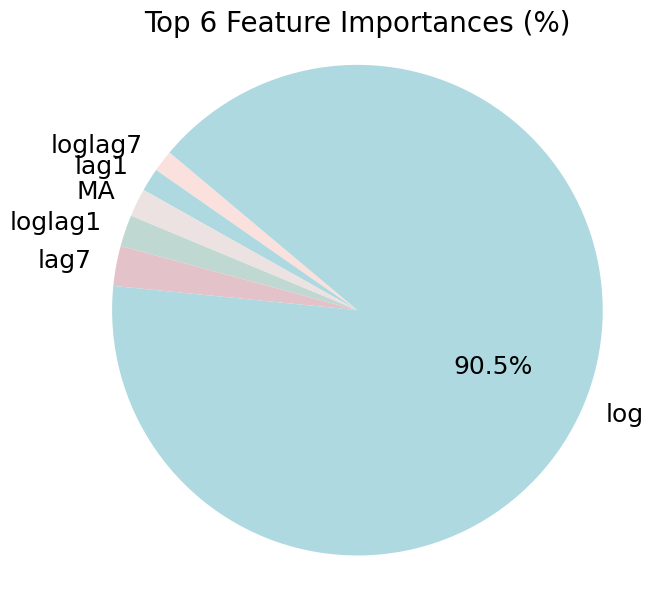

In [10]:
# 最適なモデルを取得
best_model = grid.best_estimator_

# 最適なモデルのfeature_importances_を使用
importances = best_model.feature_importances_

labels = X_train.columns

# 重要度が高い特徴量のインデックスを取得（上位5つ）
top_indices = np.argsort(importances)[-6:]

colors = ['#FAE1DD', '#AED9E0','#ECE2E1', '#BFD8D2','#E3C3C9', '#AED9E0']

# カスタムautopct関数
def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 5 else ''

# グラフの作成
plt.figure(figsize=(6, 6))  # サイズを正方形に調整
plt.title("Top 6 Feature Importances (%)", fontsize=20)

# 円グラフの描画
wedges, texts, autotexts = plt.pie(importances[top_indices] * 100, labels=[labels[i] for i in top_indices], autopct=custom_autopct, startangle=140, colors=colors)

# パーセンテージテキストのフォントサイズを設定
plt.setp(autotexts, size=18)
plt.setp(texts, size=18)  # ラベルのフォントサイズ
plt.tight_layout()
plt.axis('equal')  # 円グラフが円形になるように調整
plt.savefig("./image/Top 6 Feature Importances.jpeg", dpi=300)
plt.show()

#### モデルの予測（Random Forest）

In [11]:
predictions = grid.predict(X_test)

#### 予測結果をデータフレームに格納

In [12]:
result_df = pd.DataFrame({'Original': y_test, 'Predicted': predictions})

#### モデルの評価（Random Forest）

In [13]:
from sklearn.metrics import mean_squared_error

# 元のスケールに戻すために指数関数を適用
y_true = y_test
y_pred = predictions#★

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100

# 評価指標をデータフレームに格納
metrics_df= pd.DataFrame(
    {"RF": [rmse, mse, mae, mape]},#★
    index=['RMSE', 'MSE', 'MAE', 'MAPE'])

pd.options.display.float_format = '{:.2f}'.format
metrics_df

,RF
RMSE,2772.19
MSE,7685052.30
MAE,1642.66
MAPE,5.75


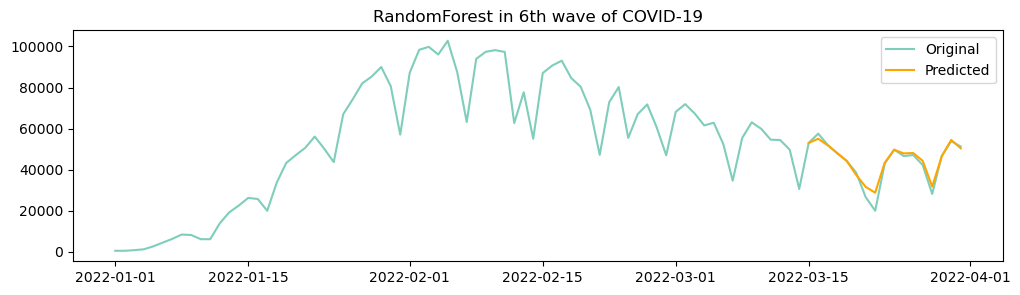

In [14]:
# 全期間の実データをプロット
plt.figure(figsize=(12,3))
plt.plot(df['original']['2022-01-01':'2022-03-31'], color='#7FCDBB', label='Original')

# テスト期間の予測データをプロット
plt.plot(y_test.index, predictions, color='orange', label='Predicted')

plt.legend()
plt.title('RandomForest in 6th wave of COVID-19')
plt.savefig("./image/rf6th1.jpeg", dpi=300)
plt.show()

#### 拡大ver

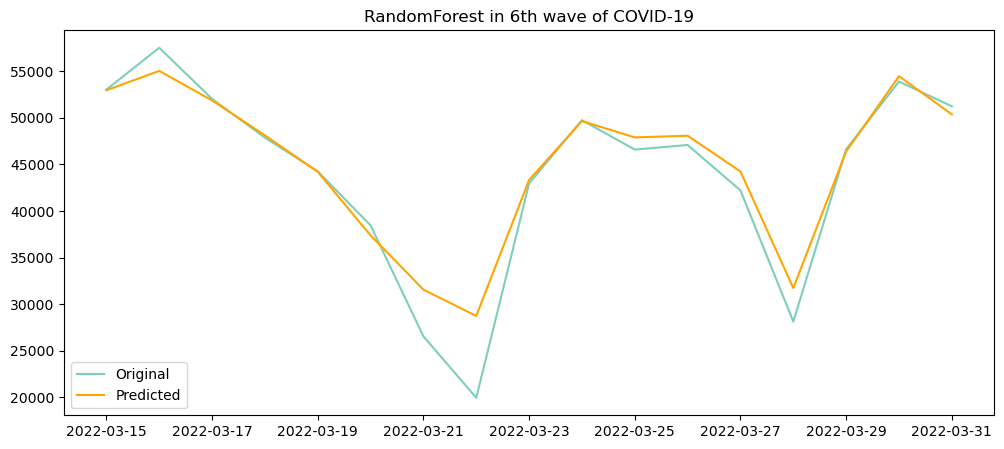

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Original', color='#7FCDBB')
plt.plot(y_test.index, predictions, label='Predicted', color='orange')
plt.title('RandomForest in 6th wave of COVID-19')
plt.legend()
plt.savefig("./image/rf6th2.jpeg", dpi=300)
plt.show()

## RFモデル（フレーム）の汎用性の確認 
〜第7波へのRandomForestの適用〜

#### データの定義

In [16]:
train_df = df["2022-07-01":"2022-09-14"]
test_df = df["2022-09-15":"2022-09-30"]

#### データの分割

In [17]:
y_train = train_df["original"]
X_train = train_df.drop(columns=["original"])

y_test = test_df["original"]
X_test = test_df.drop(columns=["original"])

#### モデルの予測（Random Forest）

In [18]:
predictions = grid.predict(X_test)

#### 予測結果をデータフレームに格納

In [19]:
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

#### モデルの評価（Random Forest）

In [20]:
from sklearn.metrics import mean_squared_error

# 変数の対応
y_true = y_test
y_pred = predictions#★

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100

# 評価指標をデータフレームに格納
metrics_df["RF7th"] = pd.DataFrame(
    {"RF7th": [rmse, mse, mae, mape]},#★
    index=['RMSE', 'MSE', 'MAE', 'MAPE'])

pd.options.display.float_format = '{:.2f}'.format
metrics_df

,RF,RF7th
RMSE,2772.19,1583.32
MSE,7685052.30,2506890.80
MAE,1642.66,1369.33
MAPE,5.75,2.98


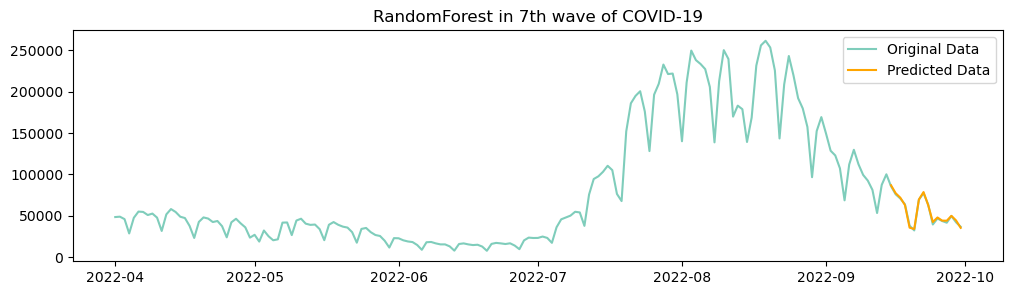

In [21]:
# 全期間の実データをプロット
plt.figure(figsize=(12,3))
plt.plot(df['original']['2022-04-01':'2022-09-30'], color='#7FCDBB', label='Original Data')

# テスト期間の予測データをプロット
plt.plot(y_test.index, predictions, color='orange', label='Predicted Data')

plt.legend()
plt.title('RandomForest in 7th wave of COVID-19')
plt.savefig("./image/rf7th1.jpeg", dpi=300)
plt.show()

#### 拡大ver

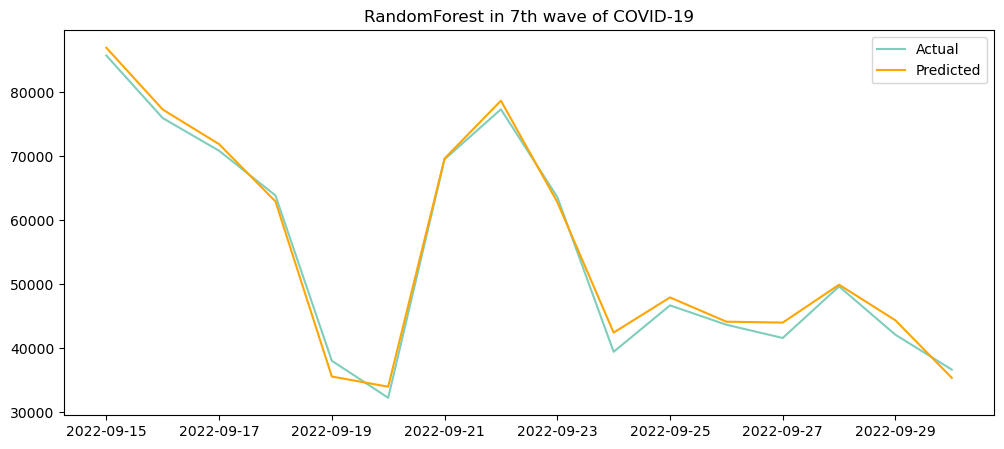

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual', color='#7FCDBB')
plt.plot(y_test.index, predictions, label='Predicted', color='orange')
plt.title('RandomForest in 7th wave of COVID-19')
plt.legend()
plt.savefig("./image/rf7th2.jpeg", dpi=300)
plt.show()

# Light GBM

In [23]:
import lightgbm as lgb

#### データの再読み込み

In [24]:
train_df = df["2022-01-01":"2022-03-14"]
test_df = df["2022-03-15":"2022-03-31"]

#### データの分割

In [25]:
y_train = train_df["original"].loc["2022-01-01":"2022-03-14"]
X_train = train_df.drop(columns=["original"]).loc["2022-01-01":"2022-03-14"]

y_test = test_df["original"]
X_test = test_df.drop(columns=["original"])

#### グリッドサーチ用のパラメータを設定

In [26]:
params = {
    'num_leaves': [2,3,5,10],
    'learning_rate': [0.001,0.005],
    'n_estimators': [300, 500,1000],
    'max_depth': [2, 3, 6],
    'min_samples_leaf': [1, 2]
}

#### パラメータサーチ

In [27]:
# モデルのインスタンス化
model = lgb.LGBMRegressor(objective="regression")

# TimeSeriesSplitの設定
tscv = TimeSeriesSplit(n_splits = 5)

# グリッドサーチの実行
grid = GridSearchCV(model, params, cv=tscv)
grid.fit(X_train, y_train)

print("Best parameters :", grid.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[Light

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[Light

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[Light

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[Light

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[Light

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[Light

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[Light

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[Light

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[Light

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[Light

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[Light

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[Light

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[Light

#### モデルを予測

In [28]:
best_model = grid.best_estimator_
predictions = best_model.predict(X_test)

#### モデルの評価（LightGBM）

In [29]:
y_true = y_test
y_pred = predictions

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100

# 評価指標をデータフレームに格納#★
metrics_df["LGBM"] = pd.DataFrame({"LGBM": [rmse, mse, mae, mape]}, index=['RMSE', 'MSE', 'MAE', 'MAPE'])

pd.options.display.float_format = '{:.2f}'.format
metrics_df

,RF,RF7th,LGBM
RMSE,2772.19,1583.32,2461.24
MSE,7685052.30,2506890.80,6057699.68
MAE,1642.66,1369.33,1886.30
MAPE,5.75,2.98,5.01


#### モデルの予測（LightGBM）

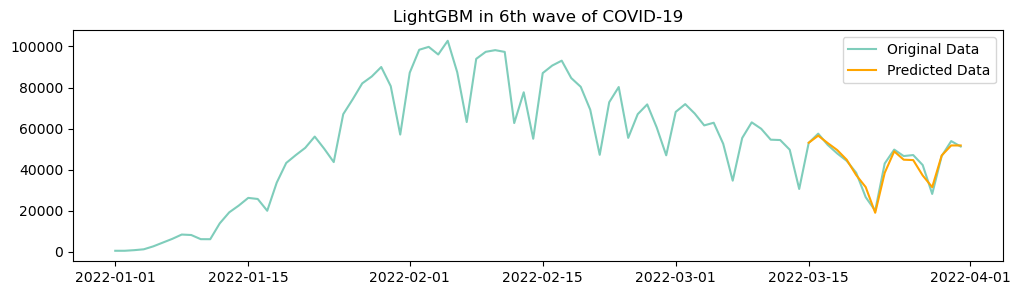

In [30]:
# 全期間の実データをプロット
plt.figure(figsize=(12,3))
plt.plot(df['original']['2022-01-01':'2022-03-31'], color='#7FCDBB', label='Original Data')

# テスト期間の予測データをプロット
plt.plot(y_test.index, predictions, color='orange', label='Predicted Data')

plt.legend()
plt.title('LightGBM in 6th wave of COVID-19')
plt.savefig("./image/lightgbm6th1.jpeg", dpi=300)
plt.show()

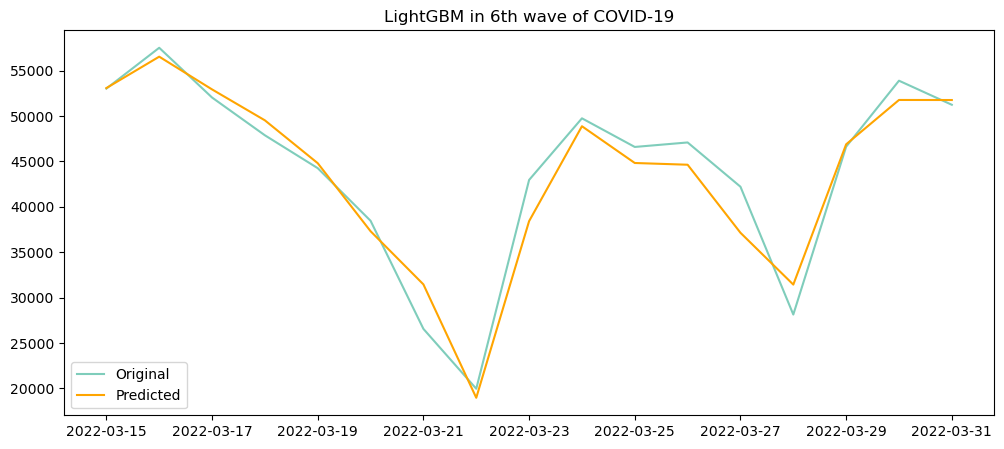

In [31]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Original', color='#7FCDBB')
plt.plot(y_test.index, predictions, label='Predicted', color='orange')
plt.title('LightGBM in 6th wave of COVID-19')
plt.legend()
plt.savefig("./image/lgbm6th2.jpeg", dpi=300)
plt.show()

## LGBMモデルの汎用性の確認 
〜第7波への適用〜

#### データの定義

In [32]:
train_df = df["2022-07-01":"2022-09-14"]
test_df = df["2022-09-15":"2022-09-30"]

#### データの分割

In [33]:
y_train = train_df["original"]
X_train = train_df.drop(columns=["original"])

y_test = test_df["original"]
X_test = test_df.drop(columns=["original"])

#### モデルの予測

In [34]:
predictions = grid.predict(X_test)

#### 予測結果をデータフレームに格納

In [35]:
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

#### モデルの評価（Random Forest）

In [36]:
from sklearn.metrics import mean_squared_error

# 変数の対応
y_true = y_test
y_pred = predictions#★

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100

# 評価指標をデータフレームに格納
metrics_df["LGBM7th"] = pd.DataFrame(
    {"LGBM7th": [rmse, mse, mae, mape]},#★
    index=['RMSE', 'MSE', 'MAE', 'MAPE'])

pd.options.display.float_format = '{:.2f}'.format
metrics_df

,RF,RF7th,LGBM,LGBM7th
RMSE,2772.19,1583.32,2461.24,2704.17
MSE,7685052.30,2506890.80,6057699.68,7312509.90
MAE,1642.66,1369.33,1886.30,2140.39
MAPE,5.75,2.98,5.01,4.81


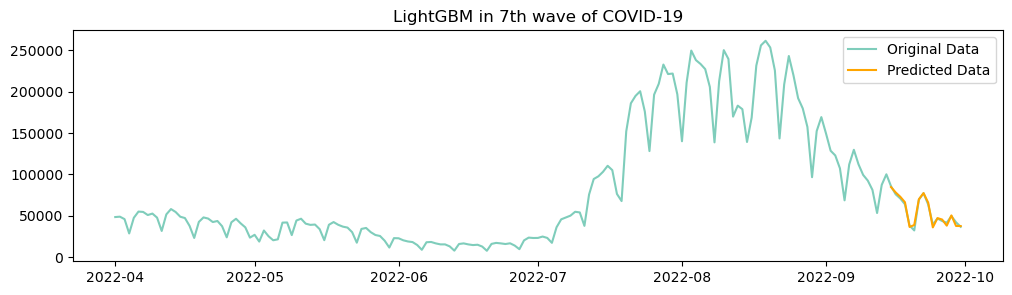

In [37]:
# 全期間の実データをプロット
plt.figure(figsize=(12,3))
plt.plot(df['original']['2022-04-01':'2022-09-30'], color='#7FCDBB', label='Original Data')

# テスト期間の予測データをプロット
plt.plot(y_test.index, predictions, color='orange', label='Predicted Data')

plt.legend()
plt.title('LightGBM in 7th wave of COVID-19')
plt.savefig("./image/lgbm7th1.jpeg", dpi=300)
plt.show()

#### 拡大ver

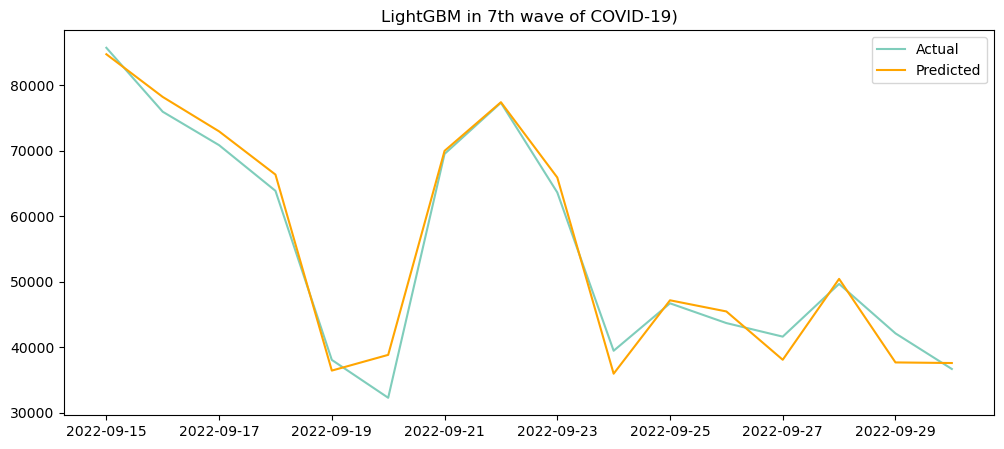

In [38]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual', color='#7FCDBB')
plt.plot(y_test.index, predictions, label='Predicted', color='orange')
plt.title('LightGBM in 7th wave of COVID-19)')
plt.legend()
plt.savefig("./image/lgbm7th2.jpeg", dpi=300)
plt.show()

fin.